# Lapage
## Analyse des ventes en ligne de la librairie

In [158]:
# import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Paramètres des graphiques
sns.set_theme(palette='deep')
sns.set_style("white")
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = [9, 5]

Pour cette analyse, nous avons à disposition 3 fichiers csv :
 - transactions.csv, qui regroupe les ventes sur le site ;
 - customers.csv, qui regroupe les informations sur nos clients ;
 - products.csv, qui regroupe les informations - notamment de prix et de catégorie - sur les articles vendus sur le site.
 
Ce notebook sera divisé en 4 parties :
 1. <a href=#import>Importation et nettoyage des données</a>
 2. <a href=#context>Analyse du contexte</a>
 3. <a href=#sales>Analyse des ventes</a>
 4. <a href=#corr>Recherches de corrélations</a>

### <div id='import'>1. Importation et nettoyage des données</div>
#### 1. a. Fichier transactions

In [159]:
# Lire le fichier CSV
data_transactions = pd.read_csv('data/transactions.csv')

# Afficher les cinq premières lignes du DF
data_transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [160]:
# Afficher un résumé du DF
data_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


La première chose à corriger est le format du champ 'date', les autres variables sont cerrectes.

On ne constate pas de valeur null.

In [161]:
# Calculer les statistiques descriptives pour toutes les colonnes
data_transactions.describe(include='all')

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


On constate dans le champ date une valeur 'test...' présente 13 fois. On remarque également que la session 's_0' est présente 200 fois.

Il est probable que des tests aient été réalisés lors de la création de la base et qu'ils n'aient pas été retirés par la suite.

Voyons à quoi correspond la session 's_0'.

In [162]:
# Filtrer les transactions pour la session "s_0"
tests = data_transactions[data_transactions['session_id'] == 's_0']

# Calculer les statistiques descriptives pour toutes les colonnes
tests.describe(include='all')

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


In [163]:
# Afficher les identifiants des clients pour la session "s_0"
print(tests['client_id'].unique())

['ct_0' 'ct_1']


Il n'y a qu'1 id_prod, 1 session_id et 2 client_id, tout semble indiquer qu'effectivement des tests (200 itérations) ont été réalisés sur la base de données. 

Cela nous donne déjà plusieurs infos pour le nettoyage des différentes tables :
 - la session 's_0' est une session de test ;
 - le produit 'T_0' est un produit de test ;
 - les clients 'ct_0' et 'ct_1' sont des clients de test.

In [164]:
# Filtrer les transactions pour la session "s_1"
tests = data_transactions[data_transactions['session_id'] == 's_1']
print(tests)

       id_prod                        date session_id client_id
480642  0_1259  2021-03-01 00:01:07.843138        s_1     c_329


La session 's_1' est une vraie transactions, il ne semble donc pas y avoir d'autres testes

In [165]:
del tests

# Supprimer les lignes correspondant à des tests
data_transactions = data_transactions[data_transactions['session_id'] != 's_0']

# Convertir la colonne 'date' en format datetime
data_transactions['date'] = pd.to_datetime(data_transactions['date'], format='%Y-%m-%d')

# Ajouter des colonnes liées au temps pour l'agrégation
data_transactions['year_month'] = data_transactions['date'].dt.to_period('M')
data_transactions['day'] = data_transactions['date'].dt.to_period('D')

# Trier le DF par date en ordre chronologique
data_transactions.sort_values('date', inplace=True)

Après toutes ces modifications, un nouveau résumé des variables semble utile pour vérifier tous les changements.

In [166]:
# Afficher des statistiques descriptives pour toutes les colonnes, y compris les colonnes datetime
data_transactions.describe(include='all', datetime_is_numeric=True)

,id_prod,date,session_id,client_id,year_month,day
count,679332,679332,679332,679332,679332,679332
unique,3266,NaN,342315,8600,24,730
top,1_369,NaN,s_118668,c_1609,2021-09,2022-11-30
freq,2252,NaN,14,25488,33326,1311
mean,NaN,2022-03-03 15:13:19.307389696,NaN,NaN,NaN,NaN
min,NaN,2021-03-01 00:01:07.843138,NaN,NaN,NaN,NaN
25%,NaN,2021-09-08 09:14:25.055994368,NaN,NaN,NaN,NaN
50%,NaN,2022-03-03 07:50:20.817730560,NaN,NaN,NaN,NaN
75%,NaN,2022-08-30 23:57:08.555173888,NaN,NaN,NaN,NaN
max,NaN,2023-02-28 23:58:30.792755,NaN,NaN,NaN,NaN


#### 1. b. Fichier products

In [167]:
# Lire le fichier CSV et supprimer le produit de test
data_products = pd.read_csv('./data/products.csv')
data_products = data_products[data_products['id_prod'] != 'T_0']

# Afficher les cinq premières lignes du DF
data_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [168]:
# Afficher un résumé du DF
data_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3286 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB


La seule variable à corriger est la catégorie, qui n'est pas un entier mais un objet.

In [169]:
# Convertir la colonne 'categ' en type str
data_products['categ'] = data_products['categ'].astype(str)

# Afficher des statistiques descriptives pour toutes les colonnes
data_products.describe(include='all')

,id_prod,price,categ
count,3286,3286.000000,3286
unique,3286,NaN,3
top,0_1421,NaN,0
freq,1,NaN,2308
mean,NaN,21.863597,NaN
std,NaN,29.849786,NaN
min,NaN,0.620000,NaN
25%,NaN,6.990000,NaN
50%,NaN,13.075000,NaN
75%,NaN,22.990000,NaN


Il n'y a pas de doublon sur le product_id, et on ne constate pas de valeur nulle.

Par contre, on a 3286 produit, contre 'seulement' 3267 dans les transactions, ce qui signifie qu'il y a des produits non vendus. Nous verrons cela dans la partie analyse.

#### 1. c. Fichier customers

In [170]:
# Lire le fichier CSV et supprimer les clients de test
data_customers = pd.read_csv('./data/customers.csv')
data_customers = data_customers[~data_customers['client_id'].isin(['ct_0', 'ct_1'])]

# Afficher les cinq premières lignes du DF
data_customers.head()


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [171]:
# Afficher un résumé du DF
data_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8621 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 269.4+ KB


Les types des variables sont correctes, et on ne constate pas de valeur nulle

In [172]:
# Afficher des statistiques descriptives pour toutes les colonnes
data_customers.describe(include='all')

,client_id,sex,birth
count,8621,8621,8621.000000
unique,8621,2,NaN
top,c_4410,f,NaN
freq,1,4490,NaN
mean,NaN,NaN,1978.275606
std,NaN,NaN,16.917958
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


Il n'y a pas de doublon sur le client_id, et on a bien deux modalités de genre.

Tout semble normal, il ne manque que quelques informations pour classer les clients par âge plus facilement qu'avec leur année de naissance.

In [173]:
# Calculer l'âge des clients en se basant sur l'année de naissance
data_customers['age'] = pd.to_datetime('today').year - data_customers['birth']

# Ajouter une catégorie par tranche d'âge de 5 ans avec une précision de 0
data_customers['age_categ'] = pd.cut(data_customers['age'], 15, precision=0)

#### 1. d. Regroupement des données

Maintenant que le nettoyage individuel de chaque table est fait, regroupons toutes les données pour vérifier que toutes les infos sont bien présentes pour les transactions.

In [174]:
# Regrouper toutes les tables
data = data_transactions.merge(data_products, on='id_prod', how='left').merge(data_customers, on='client_id', how='left')

# Afficher les cinq premières lignes du DF
data.head()

,id_prod,date,session_id,client_id,year_month,day,price,categ,sex,birth,age,age_categ
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,2021-03,2021-03-01,11.99,0,f,1967,56,"(54.0, 59.0]"
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,2021-03,2021-03-01,19.37,0,m,1960,63,"(59.0, 64.0]"
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,2021-03,2021-03-01,4.50,0,m,1988,35,"(34.0, 39.0]"
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,2021-03,2021-03-01,6.55,0,f,1989,34,"(29.0, 34.0]"
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,2021-03,2021-03-01,16.49,0,f,1956,67,"(64.0, 69.0]"


In [175]:
# Afficher un résumé du DF
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   year_month  679332 non-null  period[M]     
 5   day         679332 non-null  period[D]     
 6   price       679111 non-null  float64       
 7   categ       679111 non-null  object        
 8   sex         679332 non-null  object        
 9   birth       679332 non-null  int64         
 10  age         679332 non-null  int64         
 11  age_categ   679332 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(5), period[D](1), period[M](1)
memory usage: 62.8+ MB


In [176]:
# Afficher des statistiques descriptives pour toutes les colonnes
data.describe(include='all', datetime_is_numeric=True)

,id_prod,date,session_id,client_id,year_month,day,price,categ,sex,birth,age,age_categ
count,679332,679332,679332,679332,679332,679332,679111.000000,679111,679332,679332.000000,679332.000000,679332
unique,3266,NaN,342315,8600,24,730,NaN,3,2,NaN,NaN,15
top,1_369,NaN,s_118668,c_1609,2021-09,2022-11-30,NaN,0,m,NaN,NaN,"(39.0, 44.0]"
freq,2252,NaN,14,25488,33326,1311,NaN,415459,340930,NaN,NaN,132679
mean,NaN,2022-03-03 15:13:19.307389696,NaN,NaN,NaN,NaN,17.454773,NaN,NaN,1977.811139,45.188861,NaN
min,NaN,2021-03-01 00:01:07.843138,NaN,NaN,NaN,NaN,0.620000,NaN,NaN,1929.000000,19.000000,NaN
25%,NaN,2021-09-08 09:14:25.055994368,NaN,NaN,NaN,NaN,8.870000,NaN,NaN,1970.000000,36.000000,NaN
50%,NaN,2022-03-03 07:50:20.817730560,NaN,NaN,NaN,NaN,13.990000,NaN,NaN,1980.000000,43.000000,NaN
75%,NaN,2022-08-30 23:57:08.555173888,NaN,NaN,NaN,NaN,18.990000,NaN,NaN,1987.000000,53.000000,NaN
max,NaN,2023-02-28 23:58:30.792755,NaN,NaN,NaN,NaN,300.000000,NaN,NaN,2004.000000,94.000000,NaN


On remarque que pour les variables 'price' et 'categ' il nous manque 221 lignes.

In [177]:
# Chercher les transactions sans prix
data[data['price'].isnull()]

,id_prod,date,session_id,client_id,year_month,day,price,categ,sex,birth,age,age_categ
9,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,2021-03,2021-03-01,NaN,NaN,m,1988,35,"(34.0, 39.0]"
1585,0_2245,2021-03-02 15:55:49.728644,s_783,c_8060,2021-03,2021-03-02,NaN,NaN,f,1979,44,"(39.0, 44.0]"
6384,0_2245,2021-03-07 20:00:01.525768,s_3159,c_1189,2021-03,2021-03-07,NaN,NaN,m,1985,38,"(34.0, 39.0]"
21072,0_2245,2021-03-23 15:57:44.266387,s_10427,c_5869,2021-03,2021-03-23,NaN,NaN,f,1952,71,"(69.0, 74.0]"
25366,0_2245,2021-03-28 10:46:04.804784,s_12567,c_966,2021-03,2021-03-28,NaN,NaN,f,1981,42,"(39.0, 44.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
662077,0_2245,2023-02-10 11:54:44.891532,s_339558,c_6952,2023-02,2023-02-10,NaN,NaN,f,1977,46,"(44.0, 49.0]"
667382,0_2245,2023-02-16 05:53:01.627491,s_342289,c_7954,2023-02,2023-02-16,NaN,NaN,m,1973,50,"(49.0, 54.0]"
668150,0_2245,2023-02-17 03:03:12.668129,s_342683,c_1533,2023-02,2023-02-17,NaN,NaN,m,1972,51,"(49.0, 54.0]"
668792,0_2245,2023-02-17 20:34:06.230094,s_343000,c_1551,2023-02,2023-02-17,NaN,NaN,m,1972,51,"(49.0, 54.0]"


In [178]:
# Chercher les codes produits concernés
data.loc[data['price'].isnull(), 'id_prod'].unique()

array(['0_2245'], dtype=object)

Il semble y avoir des transactions sans prix pour le produit '0_2245'. Cela pourrait être dû à une erreur ou à une absence de données dans le fichier 'products.csv'. Il convient de vérifier et de résoudre ce problème avant de poursuivre l'analyse.

In [179]:
# Vérifier la présence du produit dans la table products
data_products[data_products['id_prod'] == '0_2245']

,id_prod,price,categ


Ce produit n'existe pas dans la base produit.

La codification du produit indique qu'il s'agit d'un produit de la catégorie 0, mais on ne peut pas connaitre son prix.

Pour voir l'impact de ces ventes sans prix sur les données de ventes on peut déjà regarder la répartition par mois.

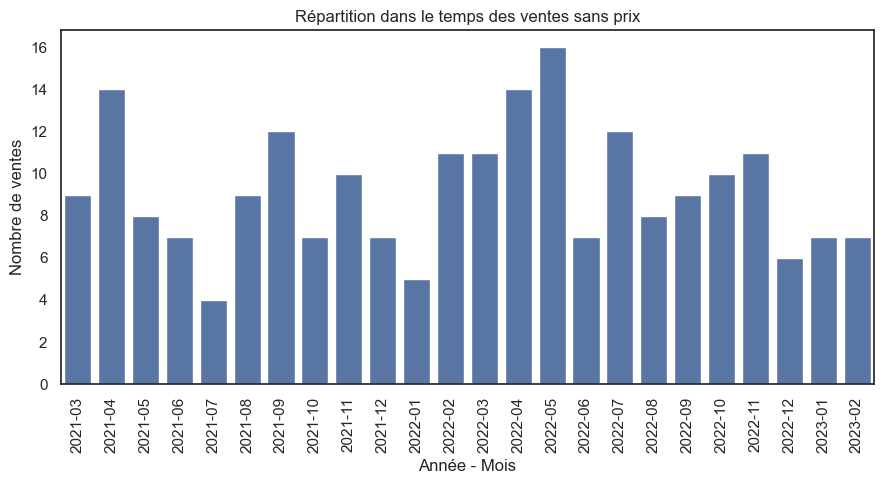

In [180]:
# Impact des ventes sans prix
plt.figure(figsize=(9, 5))
sns.countplot(data=data[data['price'].isnull()], x='year_month', color='b')
plt.title("Répartition dans le temps des ventes sans prix")
plt.xlabel("Année - Mois")
plt.ylabel("Nombre de ventes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

L'impact sur un ensemble de presque 700k lignes n'est pas significatif, d'autant que les ventes sont réparties dans le temps et qu'on ne dépasse pas les 16 ventes sur un mois.

On garde donc ces lignes pour d'éventuelles analyses par quantité, on peut ajouter la catégorie, et on ajoute le prix median de la catégorie.

In [181]:
# On met à jour la catégorie du produit 0_2245 qui a été identifié comme étant erronée
data.loc[data['id_prod'] == '0_2245', 'categ'] = '0'

# On ajoute le prix median de la catégorie 0
data.loc[data['id_prod'] == '0_2245', 'price'] = data.loc[data['categ'] == '0', 'price'].median()

Après avoir commencé l'analyse des ventes, on constate une anomalie sur le mois d'octobre 2021.

Vérifions la distribution des ventes sur ce mois.

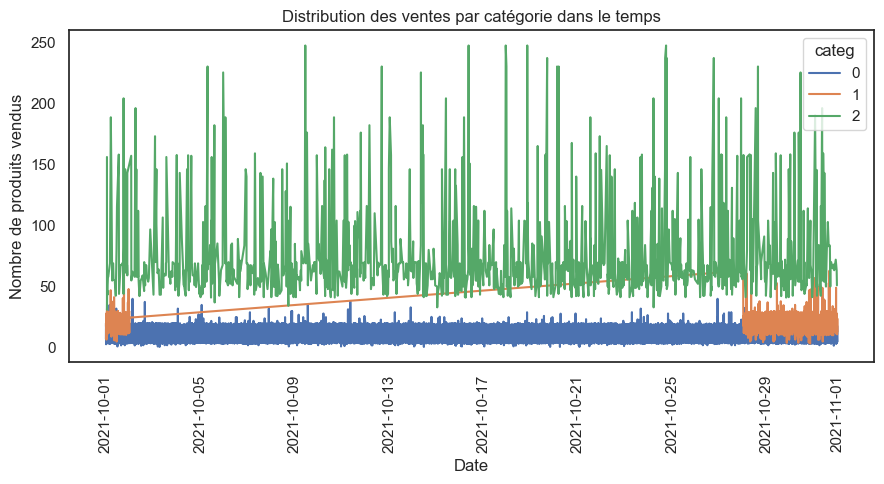

In [182]:
# Visualiser la distribution des ventes par catégorie sur le mois d'octobre 2021
plt.figure()
plt.title("Distribution des ventes par catégorie dans le temps")
sns.lineplot(data=data[data['year_month'] == '2021-10'], x='date', y='price', hue='categ', estimator='sum')
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Nombre de produits vendus")
plt.show()

On remarque une absence de données sur la majeur partie du mois d'octobre 2021 pour la catégorie 1.

Vérifions s'il s'agit d'une absence de ventes, ou d'une perte de données en regardant l'incrémentation des numéros de sessions sur l'ensemble des données.

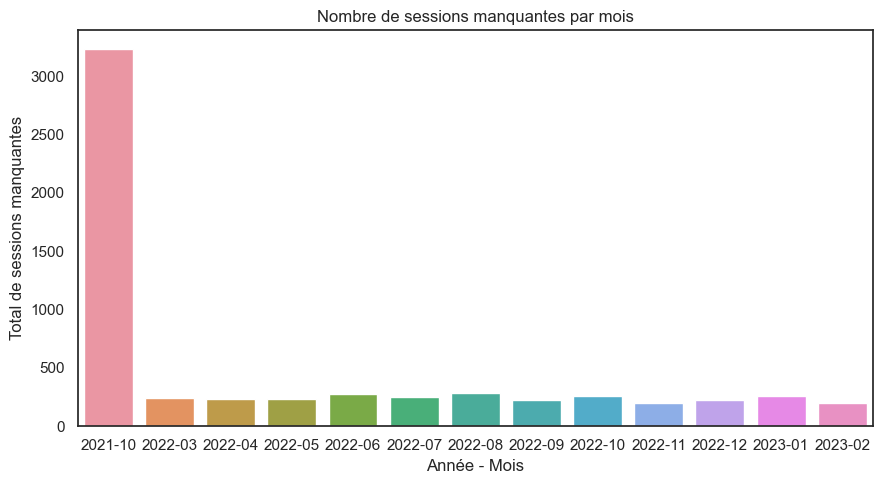

In [183]:
# On commence par récupérer le numéro de session sous forme d'entier pour pouvoir les classer dans l'ordre chronologique.
data['session_int'] = data['session_id'].str.split("_")
data['session_int'] = data['session_int'].str[1].astype('int64')
data.sort_values('session_int', inplace=True)

# Ensuite, on calcule l'écart entre deux sessions. 
data['session_var'] = data['session_int'].diff()

# Retirer 1 pour ne garder que les sessions manquantes. 
# Ne pas tenir compte des écarts à 0 car cela correspond à la présence de plusieurs ventes sur une même session.
data.loc[data['session_var'] != 0, 'session_var'] = data.loc[data['session_var'] != 0, 'session_var'] - 1

# Visualiser le nombre de sessions manquantes cumulées par mois.
plt.figure()
plt.title("Nombre de sessions manquantes par mois")
sns.barplot(data=data[data['session_var'] > 0], x='year_month', y='session_var', estimator=sum, ci=False)
plt.xlabel("Année - Mois")
plt.ylabel("Total de sessions manquantes")
plt.show()

La quantité de données manquantes sur le mois d'octobre 2021 est impactante pour les analyses de chiffres d'affaires, il faudra donc faire abstraction de ce mois.

Sur les autres mois, cela est moins significatif (mais non anodin) et semble équitablement réparti dans le temps, on va donc considérer que cela n'impacte pas l'analyse globale.

In [184]:
# Exclure le mois d'octobre 2021 pour la suite des analyses
data = data[data['year_month'] != '2021-10']

### <div id='context'> 2. Analyse du contexte</div>

Avant de faire une analyse des ventes, il est intéressant de revoir le contexte dans lequel se place la librairie Lapage pour ses ventes sur internet.

#### 2. a. Gammes de produits
Un premier élément de contexte peut être la gamme de prix et le nombre de référence par catégorie.

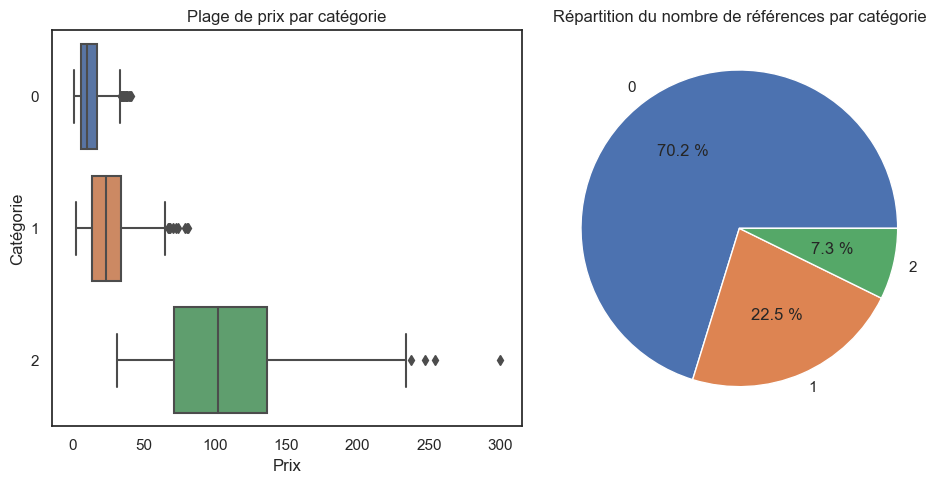

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# visualiser la dispersion des prix par catégorie.
sns.boxplot(data=data_products, x='price', y='categ', ax=ax1)
ax1.set(title="Plage de prix par catégorie", ylabel="Catégorie", xlabel="Prix")

# Visualiser le nombre de référence par catégorie
ax2.set(title="Répartition du nombre de références par catégorie")
data_nombre_references = data_products.groupby('categ')['id_prod'].count()
ax2.pie(data_nombre_references, labels=data_nombre_references.index, autopct='%.1f %%')

plt.subplots_adjust(wspace=0.5)
plt.savefig('./graphiques/products.png')
plt.show()

On constate que les 3 catégories de produits correspondent à 3 gammes de prix différentes, et que les produits de la catégorie 0 représentent plus des 2/3 des références présentes sur le site.

#### 2. b. Démographie des clients

Un deuxième élément de contexte peut être la répartition du nombre de clients par genre et par âge.

sex,f,m,Total,Total cum,percent
age_categ,,,,,
"(19.0, 24.0]",591,564,1155,1155,0.133975
"(24.0, 29.0]",422,378,800,1955,0.226772
"(29.0, 34.0]",383,383,766,2721,0.315625
"(34.0, 39.0]",433,423,856,3577,0.414917
"(39.0, 44.0]",488,436,924,4501,0.522097
"(44.0, 49.0]",450,403,853,5354,0.621042
"(49.0, 54.0]",406,351,757,6111,0.708850
"(54.0, 59.0]",375,363,738,6849,0.794455
"(59.0, 64.0]",254,242,496,7345,0.851989


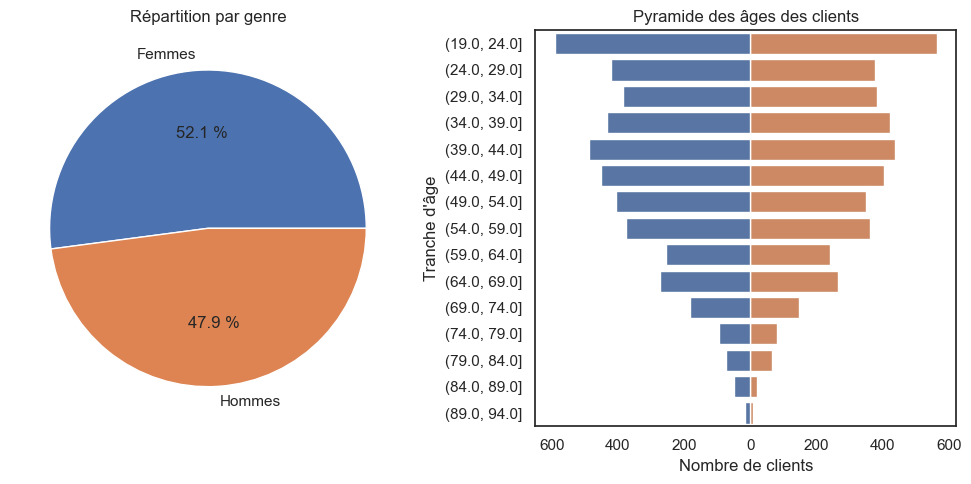

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Répartition par genre
data_sex = data_customers.groupby('sex')['client_id'].count()
ax1.pie(data_sex, autopct='%.1f %%', labels=data_sex.index.map({'f': 'Femmes', 'm': 'Hommes'}))
ax1.set_title("Répartition par genre")

# Pyramide des âges
data_age = data_customers.groupby(['sex', 'age_categ'])['client_id'].count().unstack(level=0).fillna(0)
data_age['Total'] = data_age['f'] + data_age['m']
data_age['Total cum'] = data_age['Total'].cumsum()
data_age['percent'] = data_age['Total cum'] / data_age['Total'].sum()
display(data_age)

sns.barplot( data=data_age, x='m', y=data_age.index, order=data_age.index.unique(), color='#DD8452', orient='h')
sns.barplot( data=data_age, x=-data_age['f'], y=data_age.index, order=data_age.index.unique(), color='#4C72B0', orient='h')
ax2.set_title("Pyramide des âges des clients")
ax2.set_xlabel("Nombre de clients")
ax2.set_xticks([-600, -400, -200, 0, 200, 400, 600], [600, 400, 200, 0, 200, 400, 600])
ax2.set_ylabel("Tranche d'âge")
plt.savefig('./graphiques/customers.png')
plt.show()


On constate qu'on a plus de femmes que d'hommes dans notre base clients, mais que la répartition par âge est à peu près similaire, à savoir :
 - la catégorie des 19-24 ans est nettement plus importante ;
 - de 24 à 59 ans, la densité est à peu près homogène ;
 - le nombre de client client par tranche décroit à partir de 60 ans.

### <div id='sales'>3. Analyses des ventes</div>

#### 3. a. Évolution du chiffre d'affaires depuis le lancement du site

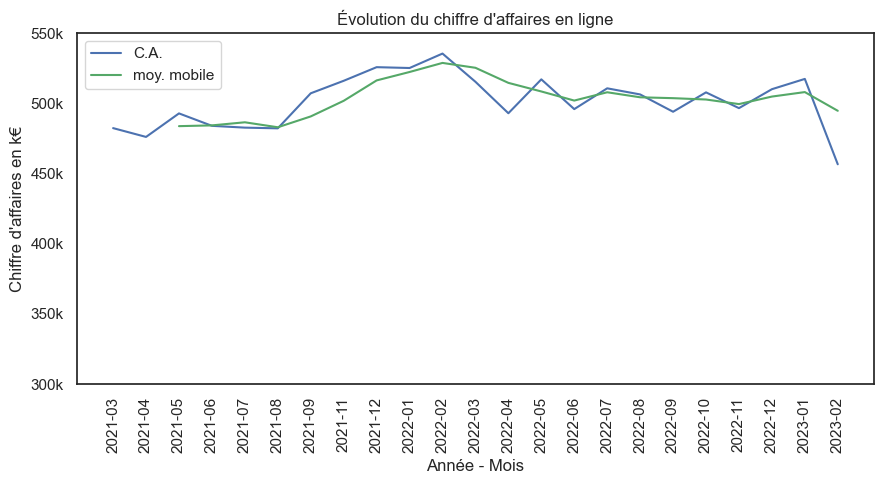

In [187]:
# Regrouper les ventes par mois
data_turnover = data.groupby(['year_month'], as_index=False)['price'].agg(['count', 'sum']).reset_index()

# Renomer les colonnes ainsi créées
data_turnover.rename(columns={'count': 'quantity', 'sum': 'turnover'}, inplace=True)

# Ajouter la moyenne mobile sur 3 mois
data_turnover['turnoverMA3'] = data_turnover['turnover'].rolling(3).mean()

# Graphique
X = data_turnover['year_month'].astype(str)
plt.figure()
plt.title("Évolution du chiffre d'affaires en ligne")
sns.lineplot(data=data_turnover, x=X, y='turnover', estimator=sum, color='b', label="C.A.")
sns.lineplot(data=data_turnover, x=X, y='turnoverMA3', estimator=sum, color='g', label="moy. mobile")
plt.ylabel("Chiffre d'affaires en k€")
plt.yticks(np.arange(300000, 600000, 50000), ['{}k'.format(int(x/1000)) for x in np.arange(300000, 600000, 50000)])
plt.xlabel("Année - Mois")
plt.xticks(rotation=90)
plt.savefig('./graphiques/courbe_ca.png')
plt.show()

In [188]:
# Chiffre d'affaires depuis le début du site
ca_total = data['price'].sum()

print("Le chiffre d'affaires depuis le lancement du site - hors octobre 2021 - est de :", "{:.2f} millions €".format(ca_total / 1000000))

Le chiffre d'affaires depuis le lancement du site - hors octobre 2021 - est de : 11.54 millions €


In [189]:
# Chiffre d'affaires 12 mois roulants
ca_12rm = data.loc[data['date'] >= '2022-03-01', 'price'].sum()

print("Le chiffre d'affaires cumulé sur les 12 derniers mois est de :", "{:.2f} millions €".format(ca_12rm / 1000000))

Le chiffre d'affaires cumulé sur les 12 derniers mois est de : 6.02 millions €


In [190]:
# Chiffre d'affaires des deux dernier mois
ca_janvier2023 = data.loc[data['year_month'] == '2023-01', 'price'].sum()
ca_fevrier2023 = data.loc[data['year_month'] == '2023-02', 'price'].sum()

# Evolution du dernier mois
print("L'évolution du chiffre d'affaires sur le mois de février 2023 est de :", "{:.2%}".format(ca_fevrier2023/ca_janvier2023 - 1))

L'évolution du chiffre d'affaires sur le mois de février 2023 est de : -11.76%


On constate également qu'on est sur une tendance à la baisse depuis février 2022.

#### 3. b. Chiffre d'affaires par produits

In [191]:
# Regrouper les ventes par produit
data_turnover_products = data.groupby(['categ', 'id_prod'], as_index=False)['price'].agg(['count', 'sum']).reset_index()

# Renomer les colonnes ainsi créées
data_turnover_products.rename(columns={'count': 'quantity', 'sum': 'turnover'}, inplace=True)

##### Répartition des ventes par catégorie.

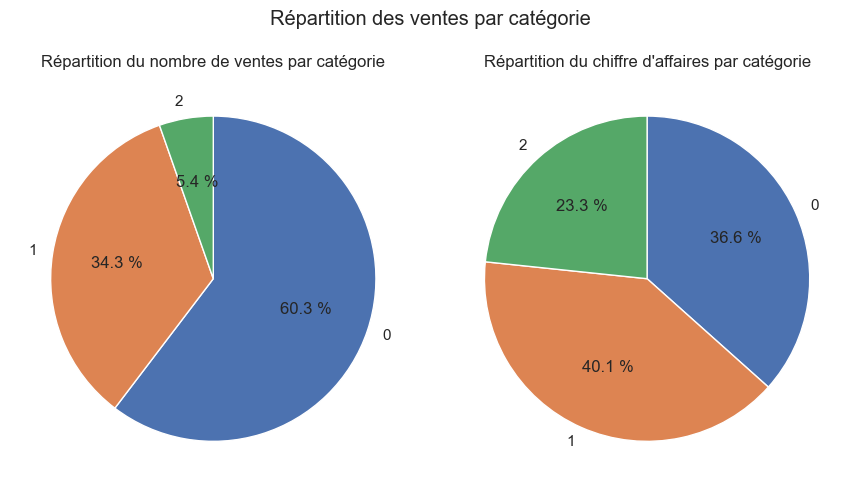

In [192]:
# Regrouper les ventes par catégorie de produit
data_turnover_categ = data_turnover_products.groupby('categ').agg({'quantity': 'sum', 'turnover': 'sum'})

# Graphiques
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Répartition des ventes par catégorie")

# Répartition du nombre de ventes par catégorie
ax1.set_title("Répartition du nombre de ventes par catégorie")
ax1.pie(data_turnover_categ['quantity'], labels = data_turnover_categ.index, autopct='%.1f %%', startangle=90, counterclock=False)

# Répartition du chiffre d'affaires par catégorie
ax2.set_title("Répartition du chiffre d'affaires par catégorie")
ax2.pie(data_turnover_categ['turnover'], labels = data_turnover_categ.index, autopct='%.1f %%', startangle=90, counterclock=False)
plt.savefig('./graphiques/sales_per_categ.png')
plt.show()


Si on compare la répartition par quantité avec la répartition du nombre de références vue au point 2.a, on constate que la catégorie 1 sur-performe avec 34% des ventes réalisées alors qu'elle ne représente que 22% des références.

C'est la catégorie 0 qui en pâtit avec 'seulement' 60% des ventes réalisées pour 70% des références présentes sur le site.

Quand à la différence de répartition du chiffre d'affaires, elle s'explique par la différence de gamme de prix des catégories.

##### Classement des ventes par produit.

Voyons d'abord la répartition des ventes par produit :

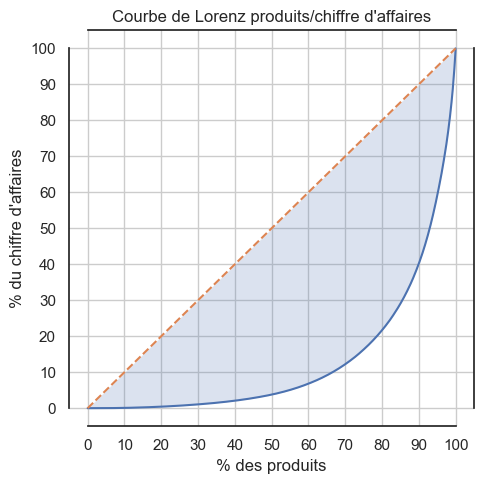

L'indice de Gini est de : 0.74


In [193]:
# Créer le df pour la courbe de Lorenz
data_lorenz_products = data_turnover_products[['id_prod', 'turnover']].sort_values('turnover').reset_index(drop=True)

# Courbe de Lorenz
n = len(data_lorenz_products)
x = np.linspace(0, 1, n)
y = np.cumsum(data_lorenz_products['turnover']) / data_lorenz_products['turnover'].sum()

plt.figure(figsize=(5, 5))
plt.title("Courbe de Lorenz produits/chiffre d'affaires")
plt.plot(x, y)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(x, y, x, alpha=0.2)
plt.xlabel("% des produits")
plt.xticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
plt.ylabel ("% du chiffre d'affaires")
plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
plt.grid()
sns.despine(top=False, right=False, trim=True)
plt.savefig('./graphiques/lorenz_product.png')
plt.show()

AUC = y.sum() / len(x)
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print("L'indice de Gini est de :", round(gini, 2))

On constate visuellement que la répartition du chiffre d'affaires par produit est proche de la loi de Pareto avec 20% des produits qui réalisent 80% du chiffre d'affaires.

Cette inégalité de répartition est confirmée par l'indice de Gini.

<blockquote><cite><a href='https://www.insee.fr/fr/metadonnees/definition/c1551'>INSEE</a></cite><p>L'indice (ou coefficient) de Gini est un indicateur synthétique permettant de rendre compte du niveau d'inégalité pour une variable et sur une population donnée. Il varie entre 0 (égalité parfaite) et 1 (inégalité extrême). Entre 0 et 1, l'inégalité est d'autant plus forte que l'indice de Gini est élevé.

Il est égal à 0 dans une situation d'égalité parfaite où la variable prend une valeur identique sur l’ensemble de la population. À l'autre extrême, il est égal à 1 dans la situation la plus inégalitaire possible, où la variable vaut 0 sur toute la population à l’exception d’un seul individu.</p></blockquote>


Les produits les plus vendus :

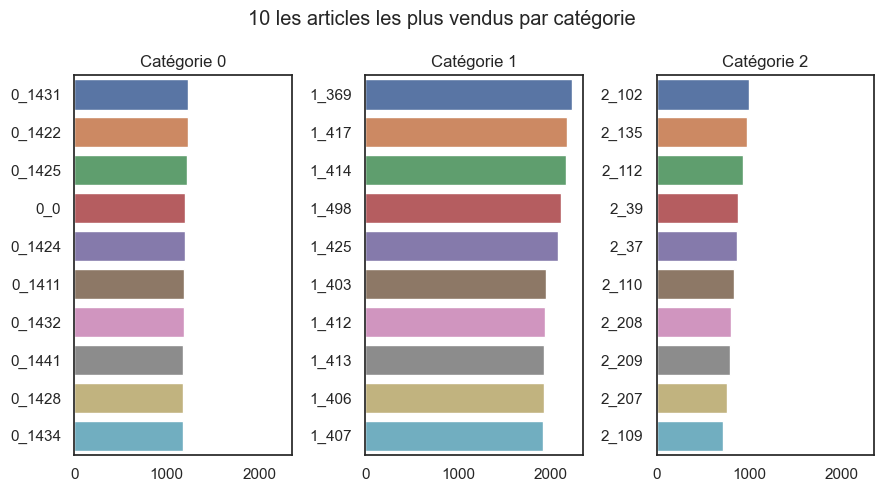

In [194]:
# Graphique top 10
plt.subplots(1, 3, sharex=True)
plt.suptitle("10 les articles les plus vendus par catégorie")
for c in data_turnover_products['categ'].unique():
    plt.subplot(131 + int(c))
    sns.barplot(data=data_turnover_products[data_turnover_products['categ'] == c].sort_values('quantity', ascending=False,).head(10), 
                y='id_prod', x='quantity', orient='h')
    plt.title(f"Catégorie {c}")
    plt.xlabel(None)
    plt.ylabel(None)

plt.savefig('./graphiques/top10_products.png') 
plt.show()

Les produits les moins vendus :

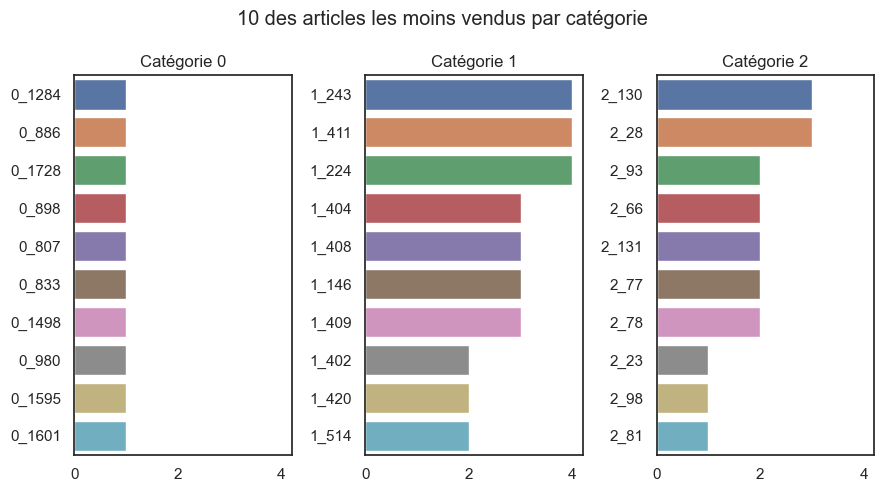

In [195]:
# Graphique flop 10
plt.subplots(1, 3, sharex=True)
plt.suptitle("10 des articles les moins vendus par catégorie")
for c in data_turnover_products['categ'].unique():
    plt.subplot(131 + int(c))
    sns.barplot(data=data_turnover_products[data_turnover_products['categ'] == c].sort_values('quantity', ascending=False,).tail(10), 
                y='id_prod', x='quantity', orient='h')
    plt.title(f"Catégorie {c}")
    plt.xlabel(None)
    plt.ylabel(None)
    
plt.savefig('./graphiques/flop10_products.png') 
plt.show()

On s'est attaché ici à analyser les produits présents dans la table des transactions. Seulement on a vu précédemment qu'il y a également des produits invendus.

In [196]:
# Filtre la liste des invendus
invendus = data_products[~data_products['id_prod'].isin(data_transactions['id_prod'])].sort_values('id_prod').reset_index()

print(invendus)
print("\nIl y a {} produits invendus sur un total de {}, soit {:.2%}.".format(invendus.shape[0], len(data_products), invendus.shape[0]/len(data_products)))

    index id_prod   price categ
0     811  0_1014    1.15     0
1     184  0_1016   35.06     0
2    1543  0_1025   24.99     0
3     737  0_1062   20.08     0
4     794  0_1119    2.99     0
5    1031  0_1318   20.92     0
6    1530  0_1620    0.80     0
7    2408  0_1624   24.50     0
8    1347  0_1645    2.99     0
9     279  0_1780    1.67     0
10   1139  0_1800   22.05     0
11   3096  0_2308   20.28     0
12   2690   0_299   22.99     0
13   2215   0_310    1.94     0
14   1505   0_322    2.99     0
15   3031   0_510   23.66     0
16    846     1_0   31.82     1
17   1863   1_394   39.73     1
18   1946    2_72  141.32     2
19   2525    2_86  132.36     2
20   1709    2_87  220.99     2

Il y a 21 produits invendus sur un total de 3286, soit 0.64%.


#### 3. c. Chiffre d'affaires par client

##### Répartition du chiffre d'affaires par client

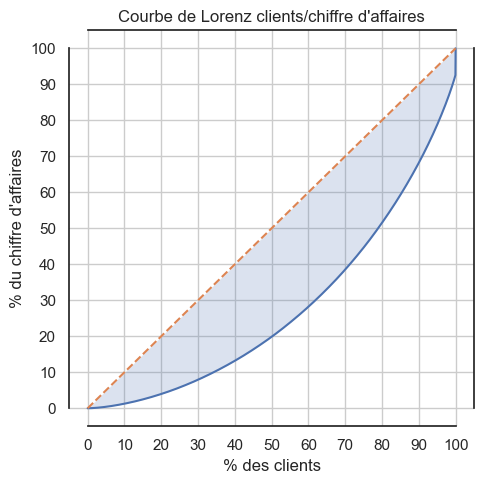

In [197]:
# Regrouper les ventes par client
data_turnover_customers = data.groupby(['client_id', 'age', 'sex'], as_index=False)['price'].agg(['count', 'sum']).reset_index()

# Renomer les colonnes
data_turnover_customers.rename(columns={'count': 'quantity', 'sum': 'turnover'}, inplace=True)

# Trier le DF par C.A croissant
data_turnover_customers.sort_values('turnover', ascending=True, inplace=True)

# Courbe de Lorenz
n = len(data_turnover_customers)
x = np.linspace(0, 1, n)
y = np.cumsum(data_turnover_customers['turnover']) / data_turnover_customers['turnover'].sum()

plt.figure(figsize=(5, 5))
plt.title("Courbe de Lorenz clients/chiffre d'affaires")
plt.plot(x, y)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(x, y, x, alpha=0.2)
plt.xlabel("% des clients")
plt.xticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
plt.ylabel ("% du chiffre d'affaires")
plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
plt.grid()
sns.despine(top=False, right=False, trim=True)
plt.savefig('./graphiques/lorenz_customers.png')
plt.show()

On se rend compte que la répartition du chiffre d'affaires entre les clients est plutôt inégalitaire.

On constate d'ailleurs une forte inégalité à la fin de la courbe, où moins de 1% des clients représente presque 10% du C.A.

On peut confirmer cette inégalité en calculant l'indice de Gini :

In [198]:
AUC = y.sum() / len(x)
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print("L'indice de Gini est de :", round(gini, 2))

L'indice de Gini est de : 0.45


Illustrons maintenant la forte inégalité sur les plus gros clients.

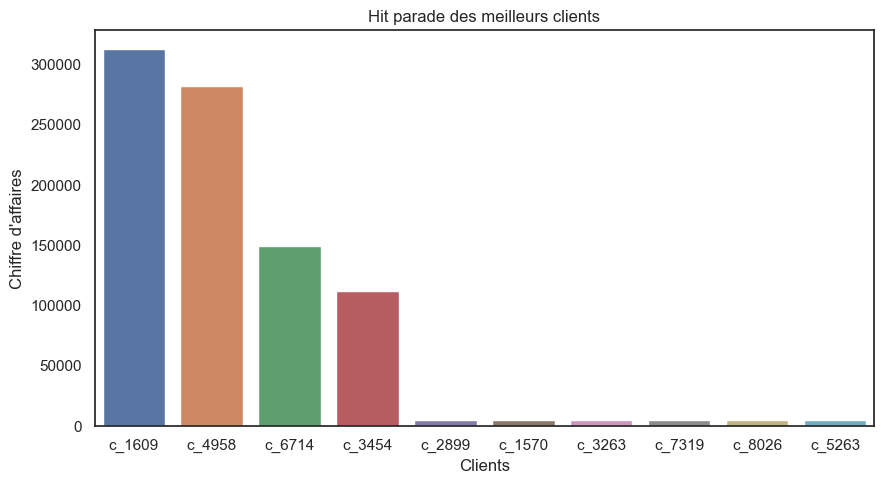

In [199]:
# liste des plus gros clients
top10_customers = data_turnover_customers.sort_values('turnover', ascending=False).head(10)

plt.figure()
plt.title("Hit parade des meilleurs clients")
sns.barplot(data=top10_customers, x='client_id', y='turnover')
plt.ylabel("Chiffre d'affaires")
plt.xlabel("Clients")
plt.savefig('./graphiques/top_10_clients.png')
plt.show()

##### Répartition des ventes par genre

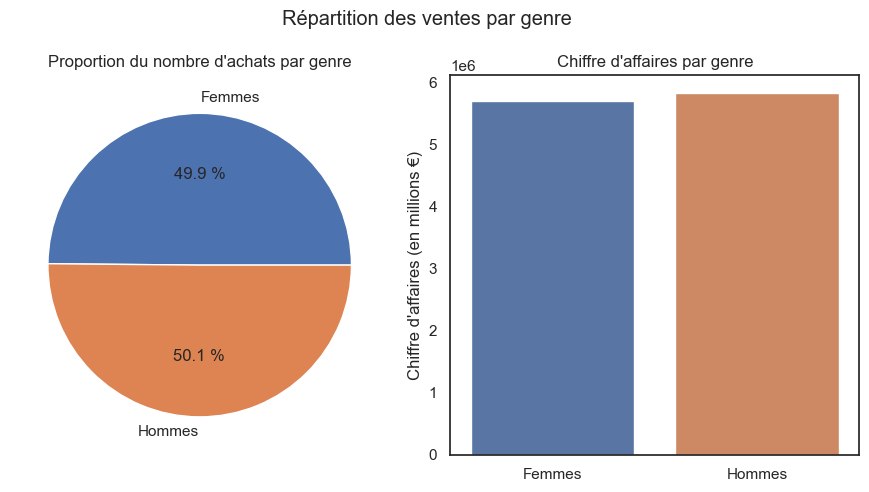

In [200]:
# Regrouper le chiffre d'affaire par genre
data_turnover_sex = data.groupby('sex')['price'].agg(['count', 'sum'])
data_turnover_sex.columns=['quantity', 'turnover']
genre = data_turnover_sex.index.map({'f': 'Femmes', 'm': 'Hommes'})

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Répartition des ventes par genre")

ax1.set_title("Proportion du nombre d'achats par genre")
ax1.pie(data_turnover_sex['quantity'], labels=genre, autopct='%.1f %%')

ax2.set_title("Chiffre d'affaires par genre")
sns.barplot(x= genre, y=data_turnover_sex['turnover'])
ax2.set_ylabel("Chiffre d'affaires (en millions €)")
ax2.set_xlabel(None)
plt.savefig('./graphiques/sales_per_sex.png')
plt.show()

In [201]:
sexes = ['f', 'm']
for sex in sexes:
    serie = data_turnover_customers.loc[data_turnover_customers['sex'] == sex, 'turnover']
    # Test de normalité de Kolmogorov-Smirnov
    stat, pval = stats.kstest(serie, 'norm')
    print(f'p-valeur de la série {sex} : {pval:.3f}')
    alpha = 0.05
    if pval > alpha:
        print(f'La série {sex} suit une distribution normale (H0 ne peut pas être rejetée)')
    else:
        print(f'La série {sex} ne suit pas une distribution normale (H0 peut être rejetée)')




p-valeur de la série f : 0.000
La série f ne suit pas une distribution normale (H0 peut être rejetée)
p-valeur de la série m : 0.000
La série m ne suit pas une distribution normale (H0 peut être rejetée)


Cependant, le théorème central limite stipule que la distribution de la moyenne d'un grand nombre d'échantillons indépendants d'une population finie suivra une distribution normale, même si la distribution de la population n'est pas normale.

In [202]:
# Sélectionner les deux séries de données
X = data_turnover_customers.loc[data_turnover_customers['sex'] == 'f', 'turnover']
Y = data_turnover_customers.loc[data_turnover_customers['sex'] == 'm', 'turnover']

# Test de Fisher pour comparer les variances des deux séries
stat, pval = stats.fisher_exact([[X.var(ddof=1), X.count()-1], [Y.var(ddof=1), Y.count()-1]])
print('p-valeur du test de Fisher :', pval)
alpha = 0.05
if pval > alpha:
    print('Les variances des deux séries sont égales (H0 ne peut pas être rejetée)')
else:
    print('Les variances des deux séries sont différentes (H0 peut être rejetée)')

p-valeur du test de Fisher : 0.0
Les variances des deux séries sont différentes (H0 peut être rejetée)


In [203]:
# Test t de Welch pour comparer les deux groupes
stat, pval = stats.ttest_ind(X, Y, equal_var=False)
print('p-valeur du test t de Welch :', pval)
alpha = 0.05
if pval > alpha:
    print('Les moyennes des deux groupes sont similaires (H0 ne peut pas être rejetée)')
else:
    print('Les moyennes des deux groupes sont différentes (H0 peut être rejetée)')

p-valeur du test t de Welch : 0.21171951113098894
Les moyennes des deux groupes sont similaires (H0 ne peut pas être rejetée)


En combinant ces deux résultats, nous pouvons dire que les deux groupes ne sont pas significativement différents en termes de chiffre d'affaires moyen, malgré une différence de leur dispersion.

##### Répartition des ventes par âge

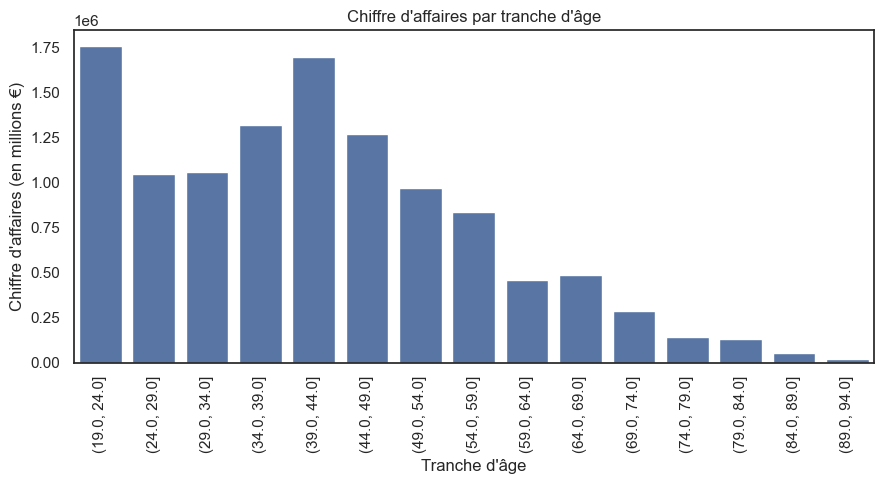

,index,age_categ,turnover,Total cum,percent
0,0,"(19.0, 24.0]",1754900.52,1754900.52,0.152136
1,1,"(24.0, 29.0]",1049628.93,2804529.45,0.243131
2,2,"(29.0, 34.0]",1055549.19,3860078.64,0.334639
3,3,"(34.0, 39.0]",1321005.96,5181084.60,0.449159
4,4,"(39.0, 44.0]",1697105.40,6878190.00,0.596285
5,5,"(44.0, 49.0]",1268504.46,8146694.46,0.706255
6,6,"(49.0, 54.0]",969653.05,9116347.51,0.790316
7,7,"(54.0, 59.0]",834139.70,9950487.21,0.862629
8,8,"(59.0, 64.0]",459229.74,10409716.95,0.902441
9,9,"(64.0, 69.0]",486343.90,10896060.85,0.944603


In [204]:
# Regrouper le chiffre d'affaires par tranche d'âge.
data_turnover_age = data.groupby(['age_categ'], as_index=False)['price'].sum(numeric_only=True).reset_index()
data_turnover_age.rename(columns={'price': 'turnover'}, inplace=True)

# Comparer le CA par tranche d'âge et catégorie de produit
plt.figure()
plt.title("Chiffre d'affaires par tranche d'âge")
sns.barplot(data=data_turnover_age, x= 'age_categ', y='turnover', color='b', estimator=sum)
plt.ylabel("Chiffre d'affaires (en millions €)")
plt.xlabel("Tranche d'âge")
plt.xticks(rotation=90)
plt.savefig('./graphiques/sales_per_age.png')
plt.show()

data_turnover_age['Total cum'] = data_turnover_age['turnover'].cumsum()
data_turnover_age['percent'] = data_turnover_age['Total cum'] / data_turnover_age['turnover'].sum()
display(data_turnover_age)

### <div id='corr'>4. Recherches de corrélations</div>

Pour chercher des corrélations les 4 plus gros clients identifiés faussent l'analyse, on créé donc un nouveau DF en les excluant pour faire nos recherches.

In [205]:
def interpreter(pval, alpha=0.05):
    if pval > alpha:
        print('Les deux variables sont indépendantes (H0 ne peut pas être rejetée)')
    else:
        print('Les deux variables ne sont pas indépendantes (H0 peut être rejetée)')

In [206]:
# Identifier les 4 plus gros clients
top4_customers = top10_customers['client_id'].head(4).to_list()

# Créer le nouveau DF
data_centre = data[~data['client_id'].isin(top4_customers)]

#### 4.a. Lien entre le genre d’un client et les catégories des livres achetés 

In [207]:
# création d'un tableau de containgeance
X='sex'
Y='categ'
cont_sex_categ = data_centre[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True)
cont_sex_categ

categ,0,1,2,All
sex,,,,
f,192025,110550,16429,319004
m,178044,100227,15351,293622
All,370069,210777,31780,612626


Le khi2 est de : 18.757882515638208
Le degrés de liberté est de : 6
La p-value est de : 0.004592685293327873
Les deux variables ne sont pas indépendantes (H0 peut être rejetée)


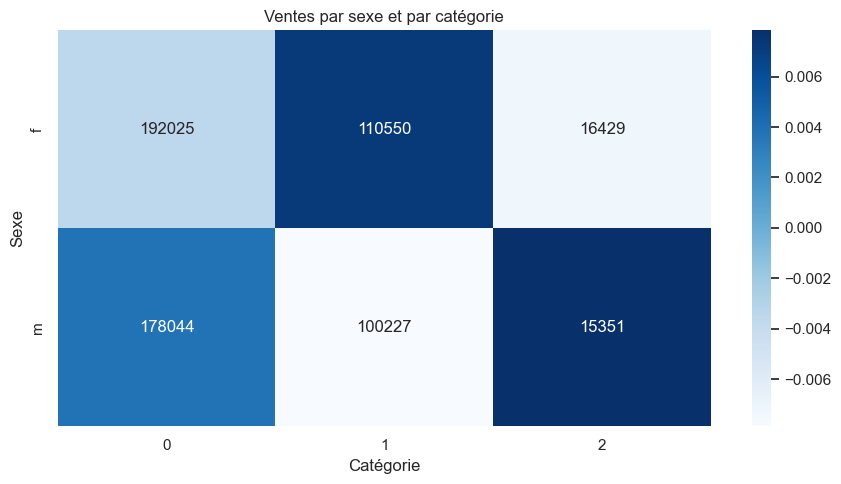

In [208]:
# test du khi2
khi2, pval , ddl , contingent_theorique = stats.chi2_contingency(cont_sex_categ)
print("Le khi2 est de :", khi2)
print("Le degrés de liberté est de :", ddl)
print("La p-value est de :", pval)

# Interprétation des résultats
interpreter(pval)

# Mesurer l'écart à l'indépendance
measure = (cont_sex_categ - contingent_theorique) / contingent_theorique

# Représenter graphiquement cet écart
plt.figure()
plt.title("Ventes par sexe et par catégorie")
sns.heatmap(measure.iloc[:-1,:-1], annot=cont_sex_categ.iloc[:-1,:-1], cmap='Blues', fmt='g')
plt.xlabel("Catégorie")
plt.ylabel("Sexe")
plt.savefig('./graphiques/sexe_categ.png')
plt.show()

#### 4. b. Lien entre l’âge des clients et le montant total des achats

In [209]:
# Regrouper le C.A. par client
data_customers_age = data_centre.groupby(['client_id', 'age'], as_index=False)['price'].sum()

# Vérifier la normalité de la distriution de l'êge des clients avec un test de Kolmogorov-Smirnov
stat, pval = stats.kstest(data_customers_age['age'], 'norm')

# Affichage des résultats
print('Statistique de test : ', stat)
print('p-value : ', pval)

# Interprétation des résultats
alpha = 0.05
if pval > alpha:
    print('Les âges des clients suivent une distribution normale (H0 ne peut pas être rejetée)')
else:
    print('Les âges des clients ne suivent pas une distribution normale (H0 peut être rejetée)')

Statistique de test :  1.0
p-value :  0.0
Les âges des clients ne suivent pas une distribution normale (H0 peut être rejetée)


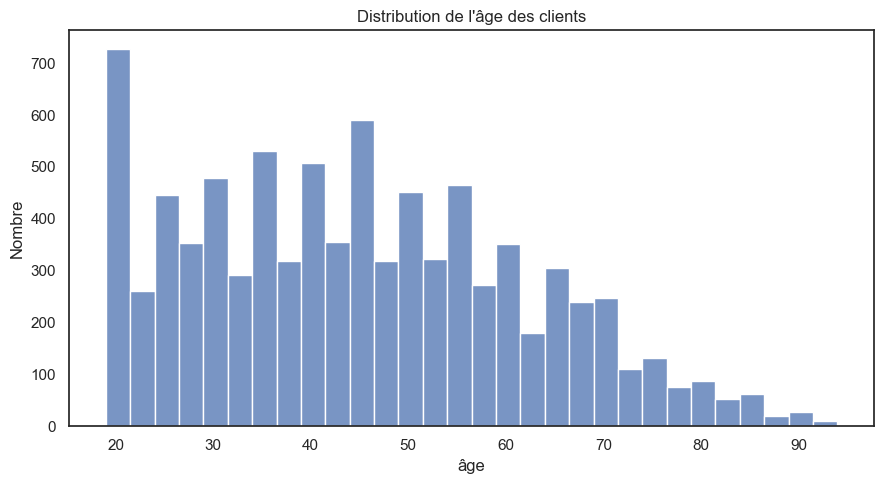

In [210]:
plt.figure()
plt.title("Distribution de l'âge des clients")
sns.histplot(data_customers_age['age'])
plt.xlabel("âge")
plt.ylabel("Nombre")
plt.savefig('./graphiques/dist_age.png')
plt.show()

Pour étudier la corrélation entre ces deux variables, il nous faut donc un test non paramétrique.

Coefficient de corrélation de Spearman :  -0.17901613661589555
p-value :  0.0
Les deux variables ne sont pas indépendantes (H0 peut être rejetée)


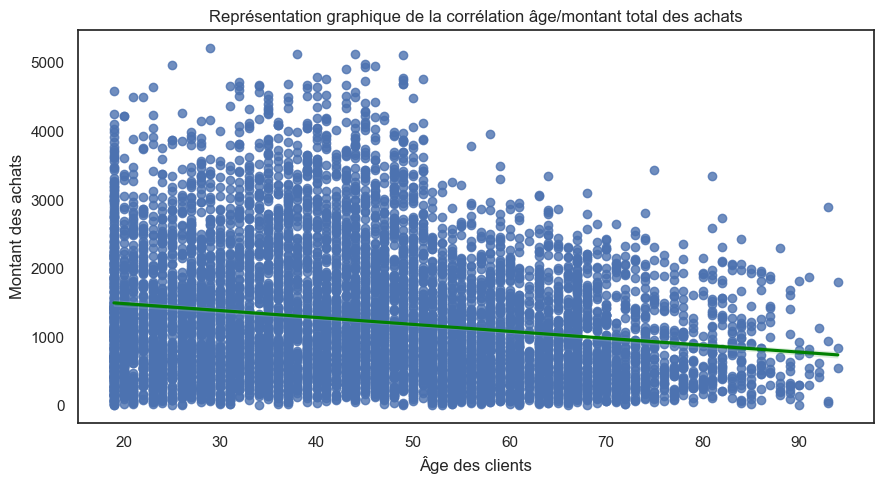

In [211]:
# Calcul de la corrélation de Spearman
x = data_customers_age['age']
y = data_customers_age['price']
corr, p = stats.spearmanr(x, y)

# Affichage des résultats
print('Coefficient de corrélation de Spearman : ', corr)
print('p-value : ', pval)

# Interprétation des résultats
interpreter(pval)

# Corrélation linéaire
plt.figure()
plt.title("Représentation graphique de la corrélation âge/montant total des achats")
sns.regplot(data=data_customers_age, x='age', y='price', line_kws={"color": "green"})
plt.ylabel("Montant des achats")
plt.xlabel("Âge des clients")
plt.savefig('./graphiques/ age_montant.png')
plt.show()

#### 4. c. Lien entre l’âge des clients et la fréquence d’achat

Coefficient de corrélation de Spearman :  0.21298780631274733
p-value :  9.751492522997272e-89
Les deux variables ne sont pas indépendantes (H0 peut être rejetée)


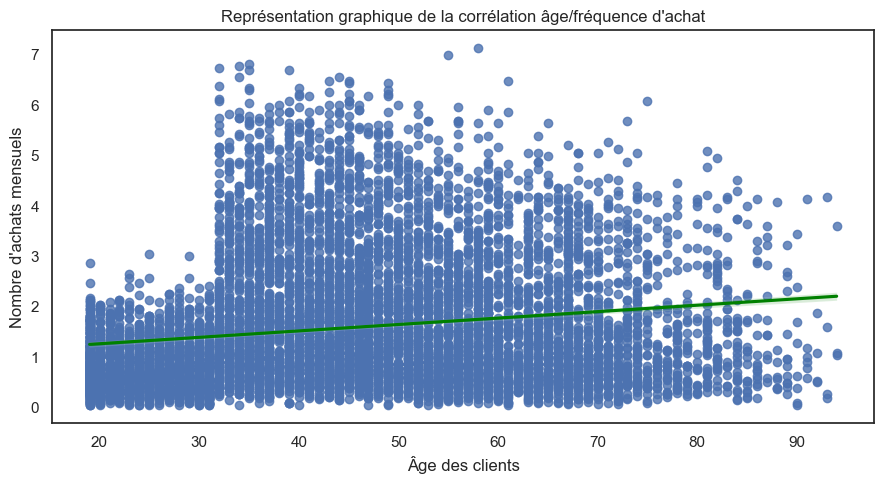

In [212]:
# Grouper par client_id, age et session_id, et trouver la première année_mois pour chaque groupe
data_freq_customers = data_centre.groupby(['client_id','age', 'session_id'], as_index=False)['year_month'].min()

# Grouper par client_id et age, compter le nombre de session_ids uniques et trouver la première année_mois pour chaque groupe
data_freq_customers = data_freq_customers.groupby(['client_id','age'], as_index=False).agg({'session_id': 'nunique', 'year_month':'min'})
data_freq_customers.columns=['client_id', 'age', 'count_session', 'first_purchase']

# Trouver la dernière année_mois
currentYear_month = np.max(data['year_month'].astype(int))

# Calculer l'ancienneté de chaque client
data_freq_customers['seniority'] = currentYear_month - data_freq_customers['first_purchase'].astype(int)

# Calculer la fréquence de chaque client
data_freq_customers['frequency'] = data_freq_customers['count_session'] / data_freq_customers['seniority']

# Calcul de la corrélation de Spearman
x = data_freq_customers['age']
y = data_freq_customers['frequency']
corr, pval = stats.spearmanr(x, y)

# Affichage des résultats
print('Coefficient de corrélation de Spearman : ', corr)
print('p-value : ', pval)

# Interprétation des résultats
interpreter(pval)

# Réprésenter graphiquement la corrélation
plt.figure()
plt.title("Représentation graphique de la corrélation âge/fréquence d'achat")
sns.regplot(data=data_freq_customers, x='age', y='frequency', line_kws={"color": "green"})
plt.ylabel("Nombre d'achats mensuels")
plt.xlabel("Âge des clients")
plt.savefig('./graphiques/age_freq.png')
plt.show()

#### 4. d. Lien entre l’âge des clients et la taille du panier moyen

Coefficient de corrélation de Spearman :  -0.6954827530099803
p-value :  0.0
Les deux variables ne sont pas indépendantes (H0 peut être rejetée)


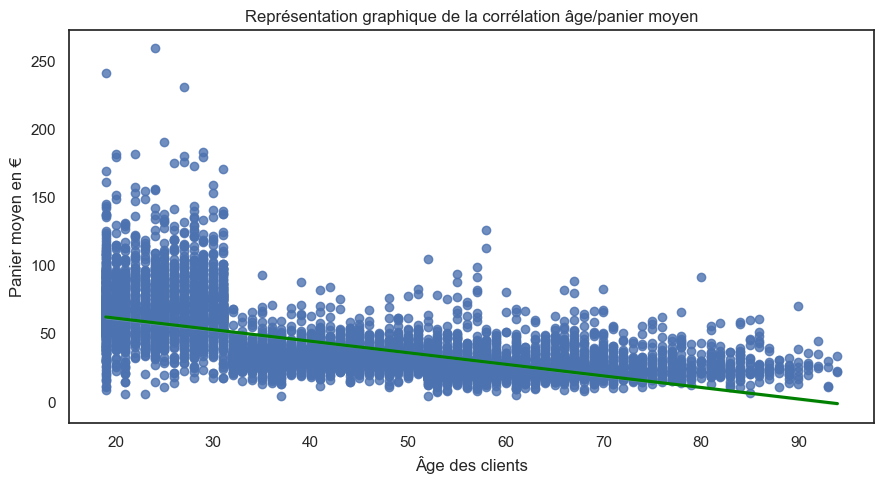

In [213]:
# Grouper par client_id, age et session_id, et la somme des achats
data_purchase_customers = data_centre.groupby(['client_id','age', 'session_id'], as_index=False)['price'].sum()

# Grouper par client_id et age, compter le nombre de session_ids uniques et le C.A. par client
data_purchase_customers = data_purchase_customers.groupby(['client_id','age'], as_index=False).agg({'session_id': 'nunique', 'price':'sum'})
data_purchase_customers.columns=['client_id', 'age', 'count_session', 'turnover']

# Calculer le panier moyen de chaque client
data_purchase_customers['avg_value'] = data_purchase_customers['turnover'] / data_purchase_customers['count_session']

# Calcul de la corrélation de Spearman
x = data_purchase_customers['age']
y = data_purchase_customers['avg_value']
corr, pval = stats.spearmanr(x, y)

# Affichage des résultats
print('Coefficient de corrélation de Spearman : ', corr)
print('p-value : ', pval)

# Interprétation des résultats
interpreter(pval)

# Représentation graphique de la corrélation
plt.figure()
plt.title("Représentation graphique de la corrélation âge/panier moyen")
sns.regplot(data=data_purchase_customers, x='age', y='avg_value', line_kws={"color": "green"})
plt.ylabel("Panier moyen en €")
plt.xlabel("Âge des clients")
plt.savefig('./graphiques/age_panier.png')
plt.show()

#### 4. e. Lien entre l’âge des clients et les catégories des livres achetés

Statistique de test :  69911.21351199699
P-value :  0.0
Les deux variables ne sont pas indépendantes (H0 peut être rejetée)


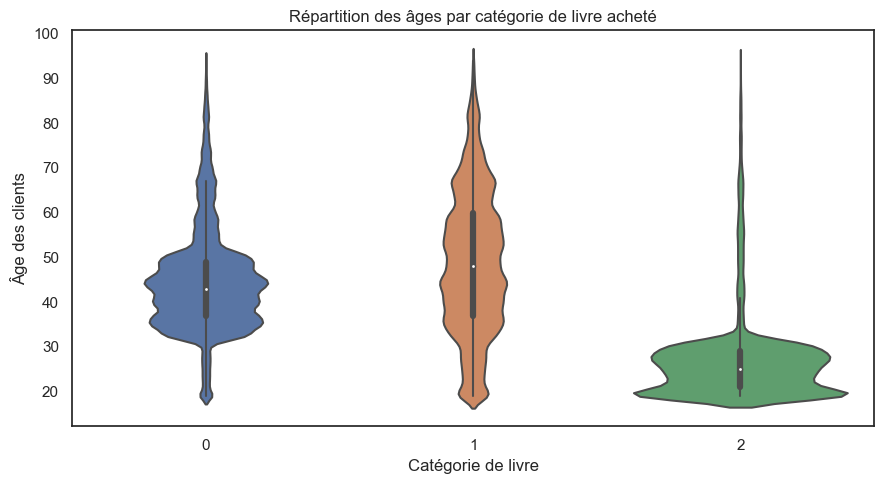

In [214]:
# Regrouper les données par catégorie de livres et calculer les statistiques descriptives de l'âge
grouped_data = data_centre.groupby("categ")["age"].apply(list)

# Effectuer le test de Kruskal-Wallis
stat, pval = stats.kruskal(*grouped_data)

# Afficher les résultats
print("Statistique de test : ", stat)
print("P-value : ", pval)

interpreter(pval)

# Graphique
plt.figure()
plt.title("Répartition des âges par catégorie de livre acheté")
sns.violinplot(data=grouped_data)
plt.ylabel("Âge des clients")
plt.xlabel("Catégorie de livre")
plt.savefig('./graphiques/age_categ.png')
plt.show()